In [1]:
# code % matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display




In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape


((60000, 28, 28), (10000, 28, 28))

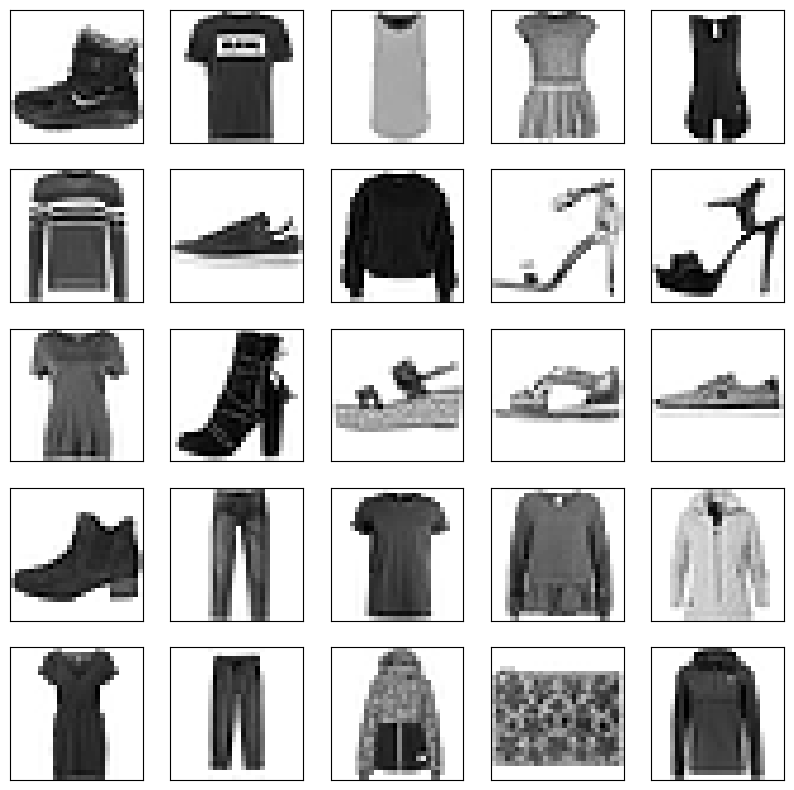

In [3]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
	plt.subplot(5, 5, i + 1)
	plt.xticks([])
	plt.yticks([])
	plt.grid(False)
	plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()


In [5]:
# code
batch_size = 32
# This dataset fills a buffer with buffer_size elements,
# then randomly samples elements from this buffer, 
# replacing the selected elements with new elements.
def create_batch(x_train):
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# Combines consecutive elements of this dataset into batches.

    dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
# Creates a Dataset that prefetches elements from this dataset
    return dataset


In [9]:
# code
num_features = 100

generator = keras.models.Sequential([
	keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
	keras.layers.Reshape([7, 7, 128]),
	keras.layers.BatchNormalization(),
	keras.layers.Conv2DTranspose(
		64, (5, 5), (2, 2), padding ="same", activation ="selu"),
	keras.layers.BatchNormalization(),
	keras.layers.Conv2DTranspose(
		1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                     

In [10]:
discriminator = keras.models.Sequential([
	keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Flatten(),
	keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [11]:
discriminator = keras.models.Sequential([
	keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Flatten(),
	keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()


Model: "sequential_4"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
          

In [12]:
# compile discriminator using binary cross entropy loss and adam optimizer
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam")
# make discriminator no-trainable as of now
discriminator.trainable = False
# Combine both generator and discriminator
gan = keras.models.Sequential([generator, discriminator])
# compile generator using binary cross entropy loss and adam optimizer

gan.compile(loss ="binary_crossentropy", optimizer ="adam")


In [13]:
seed = tf.random.normal(shape =[batch_size, 100])

def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
	generator, discriminator = gan.layers
	for epoch in tqdm(range(epochs)):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# create a random noise of sizebatch_size * 100
			# to passit into the generator
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# take batch of generated image and real image and
			# use them to train the discriminator
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
			discriminator.trainable = True
			discriminator.train_on_batch(X_fake_and_real, y1)

			# Here we will be training our GAN model, in this step
			# we pass noise that uses generatortogenerate the image
			# and pass it with labels as [1] So, it can fool the discriminator
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			gan.train_on_batch(noise, y2)

			# generate images for the GIF as we go
			generate_and_save_images(generator, epoch + 1, seed)

	generate_and_save_images(generator, epochs, seed)


In [15]:
# code
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize =(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
        plt.axis('off')

    plt.savefig('image_epoch_{:04d}.png'.format(epoch))


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10



C:\Users\hp\AppData\Local\Temp\ipykernel_6804\4260443859.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize =(10, 10))
  0%|          | 0/10 [12:13<?, ?it/s]


KeyboardInterrupt: 

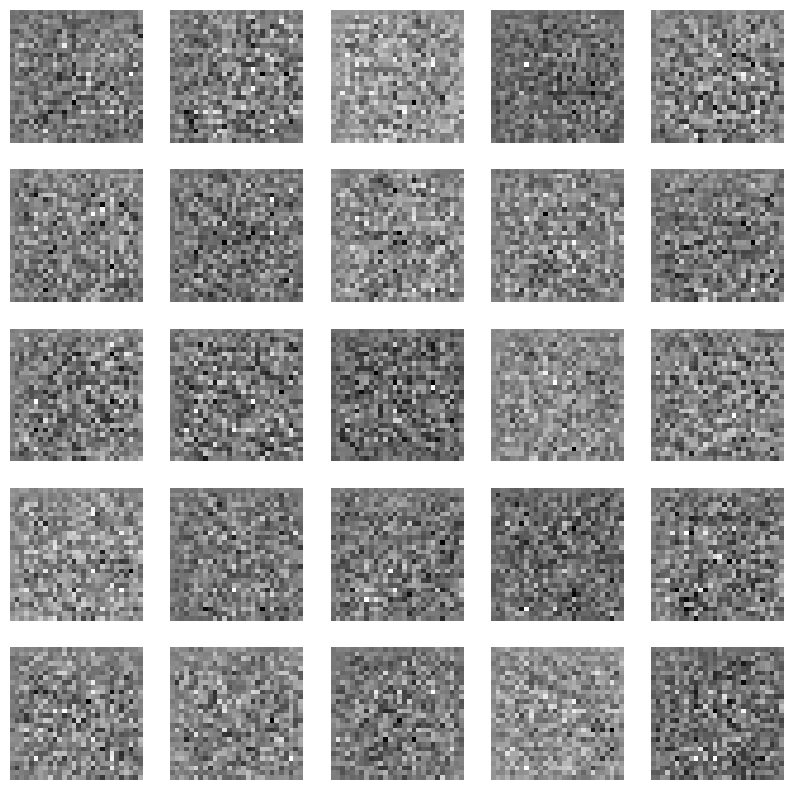

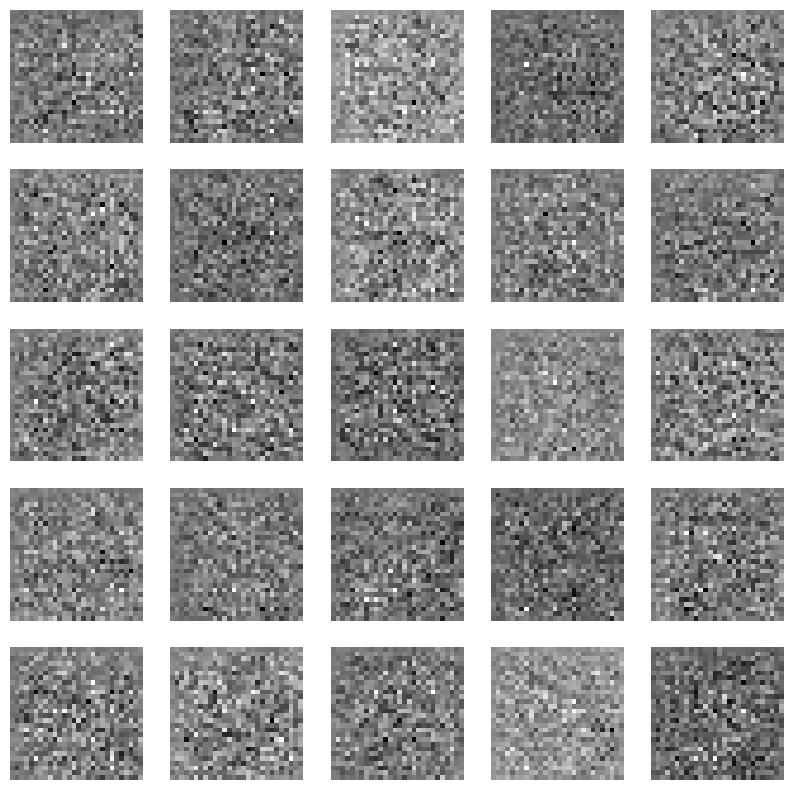

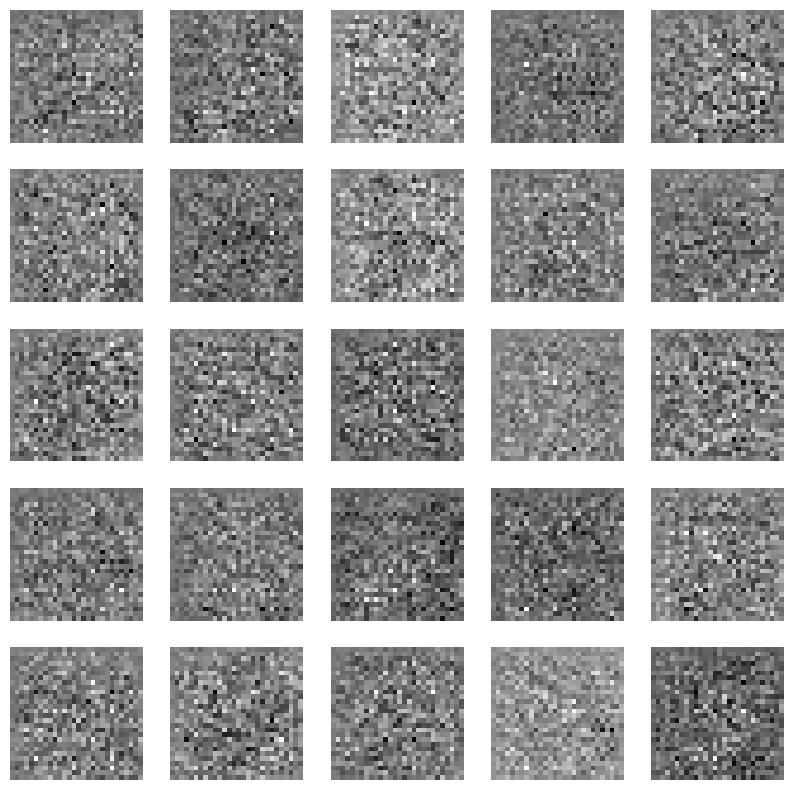

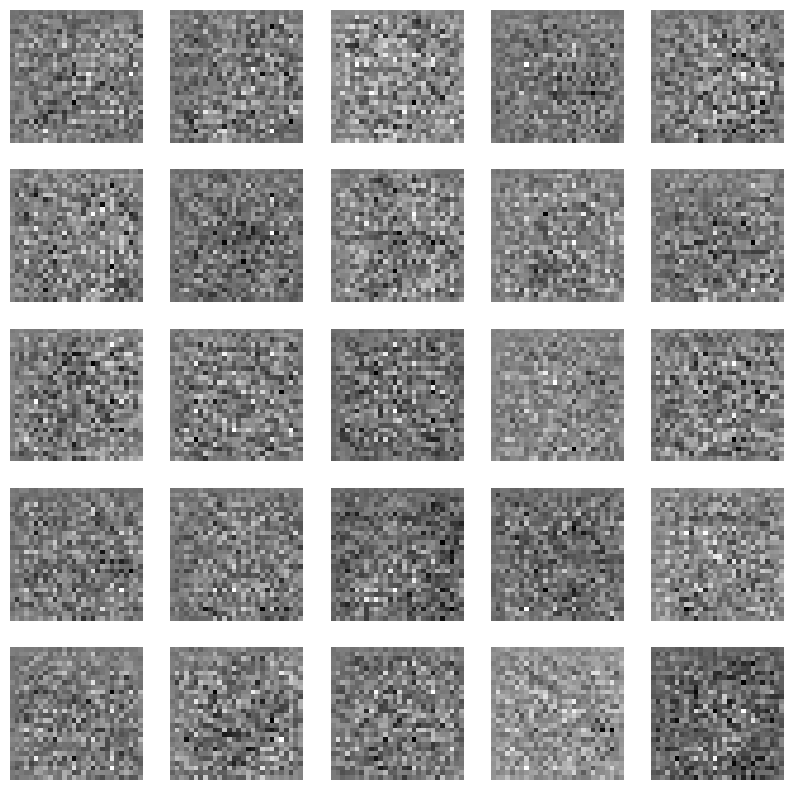

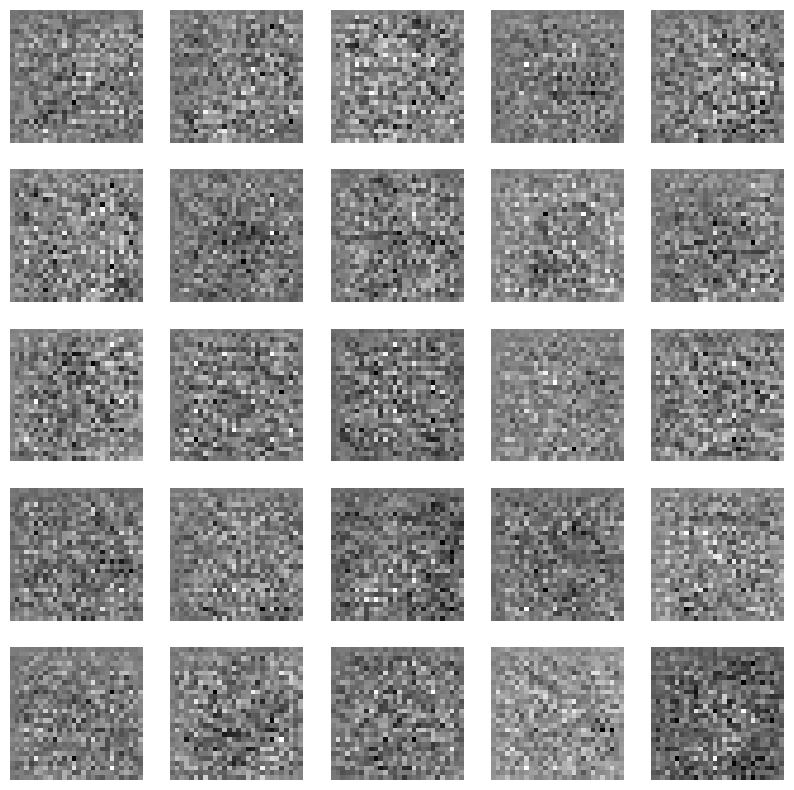

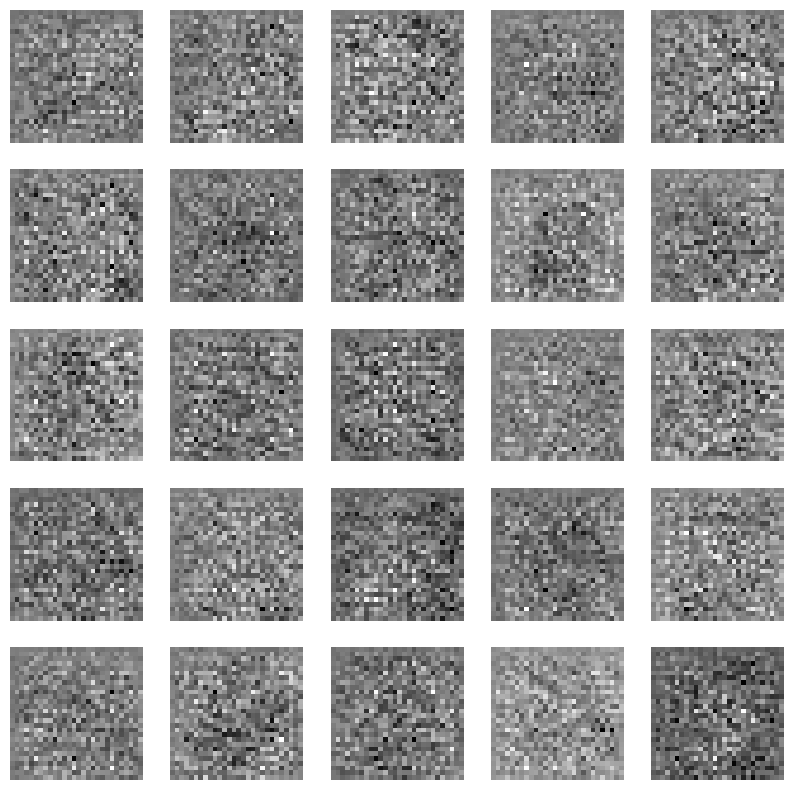

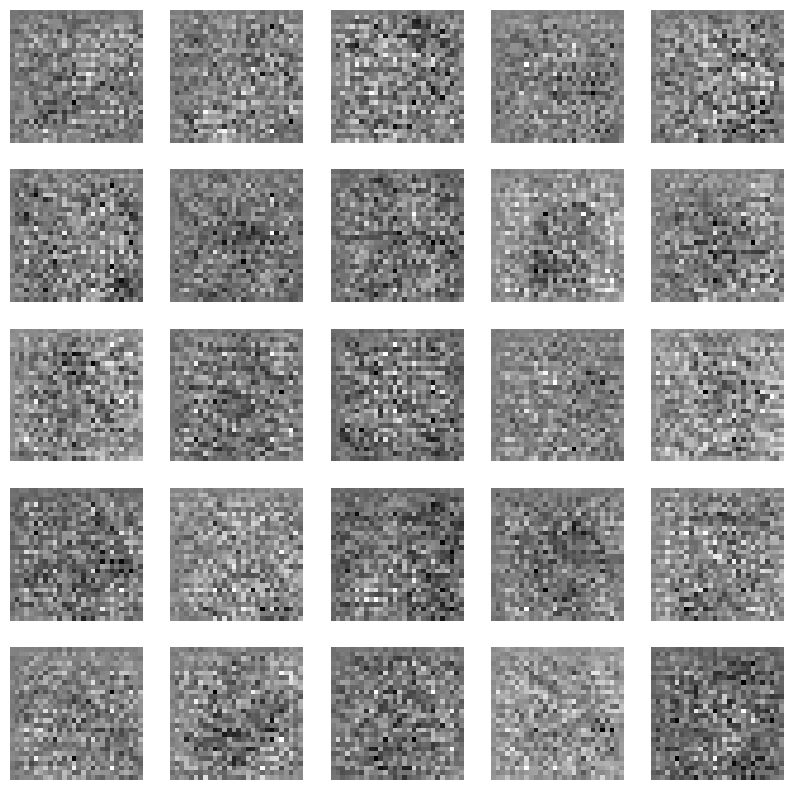

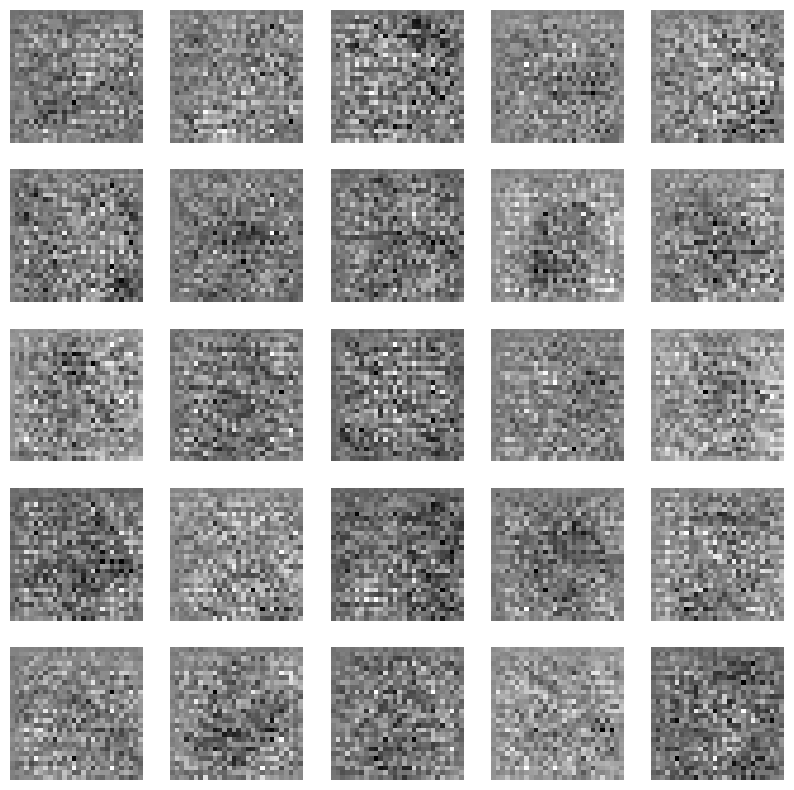

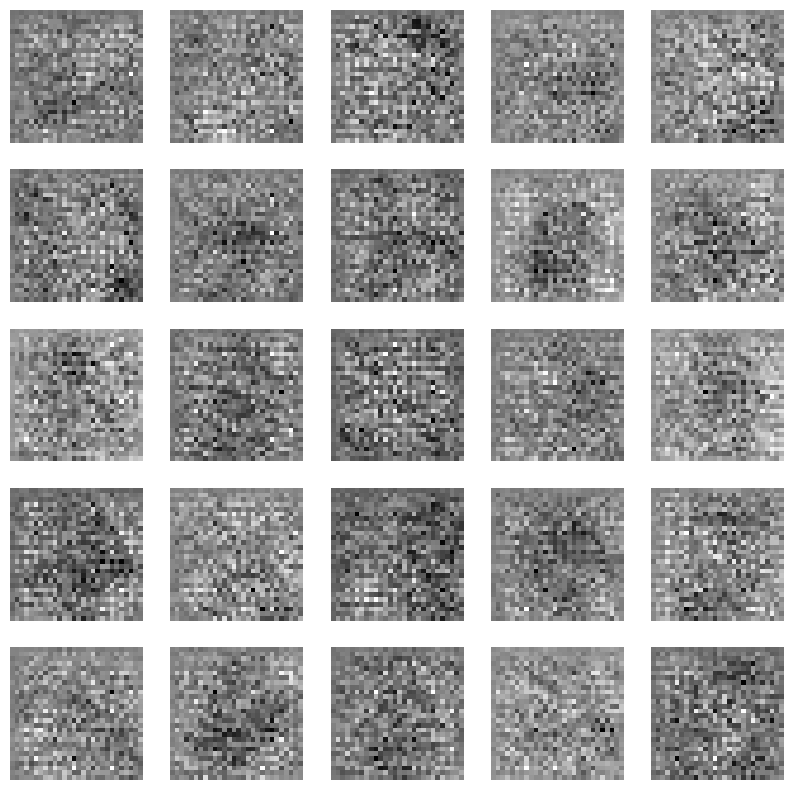

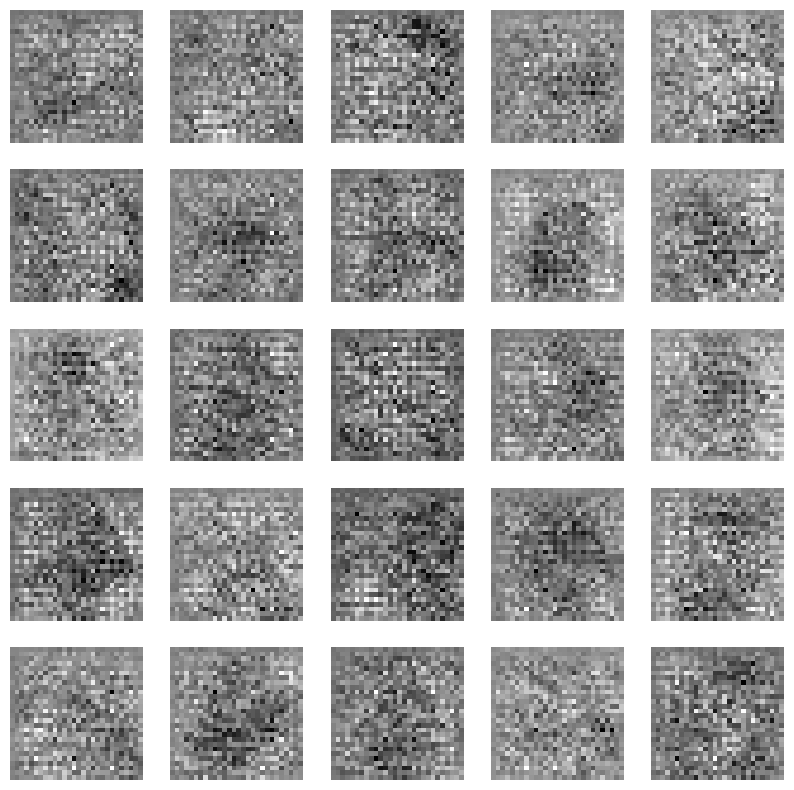

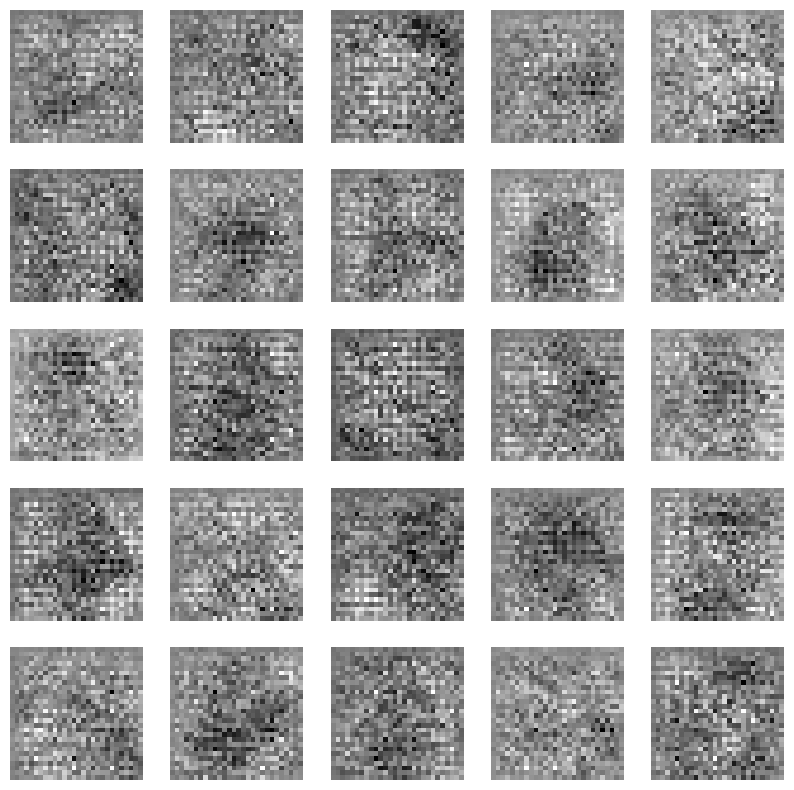

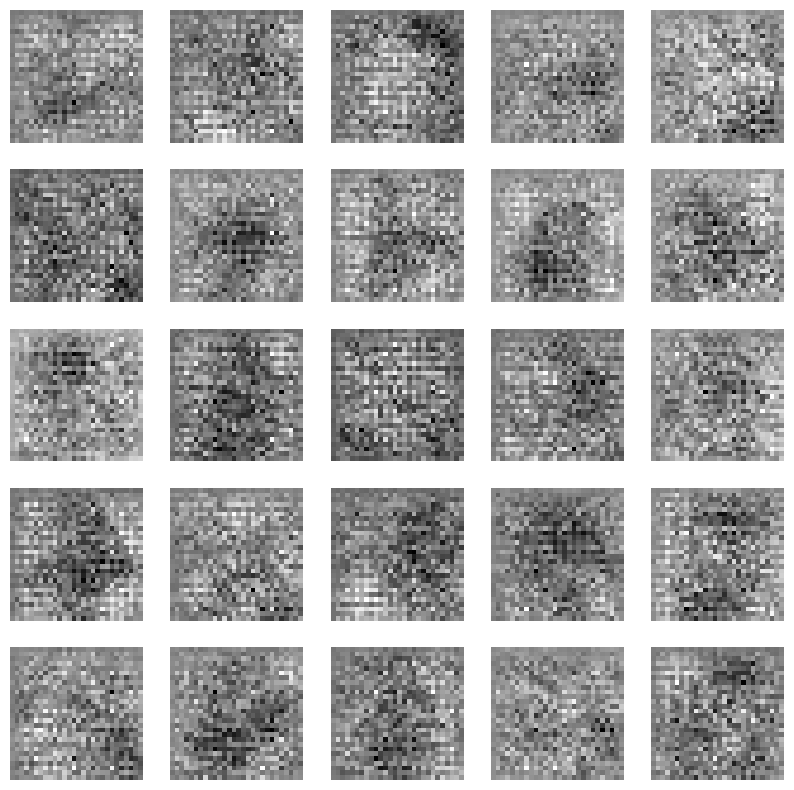

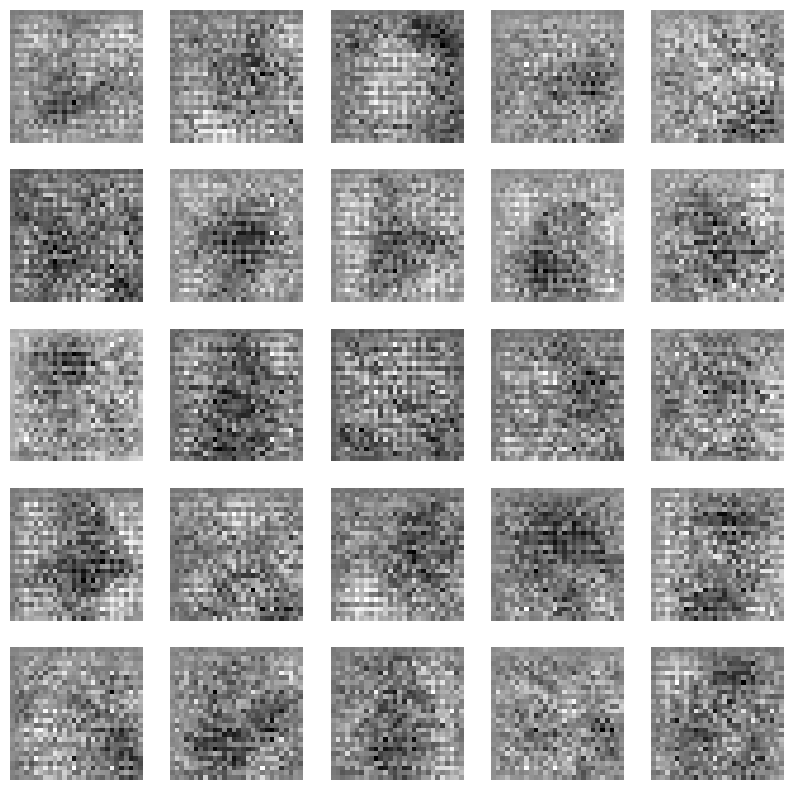

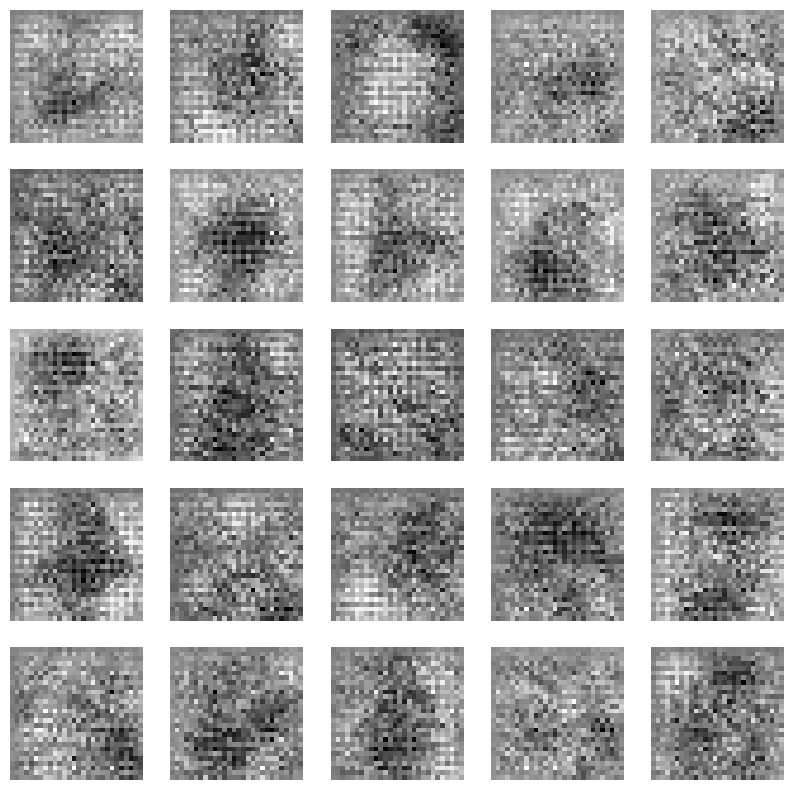

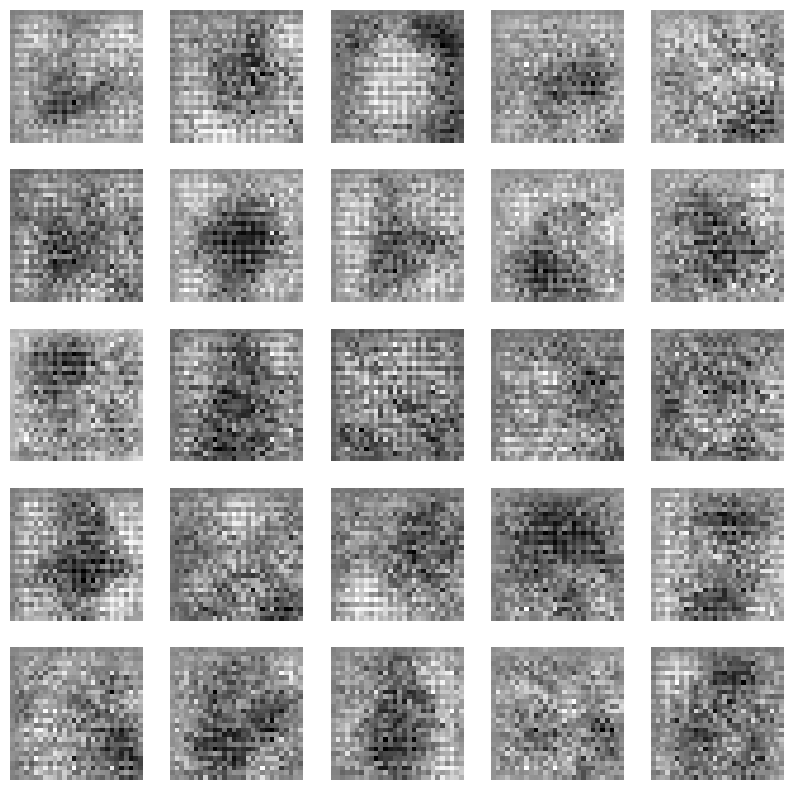

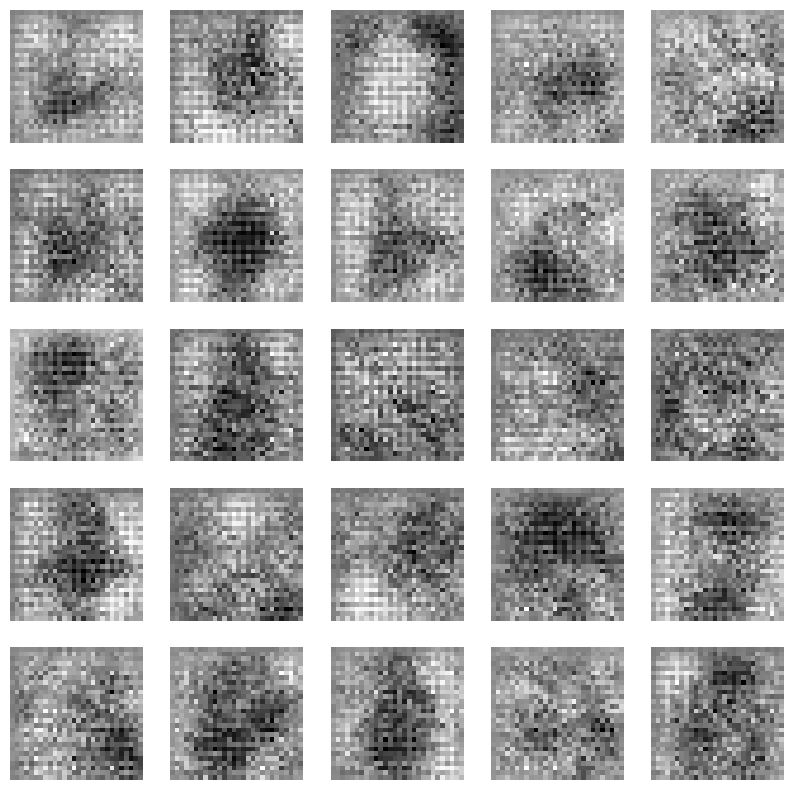

Error in callback <function flush_figures at 0x00000246412268E0> (for post_execute):


KeyboardInterrupt: 

In [16]:
# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)


In [ ]:
import imageio
import glob

anim_file = 'dcgan_results.gif'

with imageio.get_writer(anim_file, mode ='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
for i, filename in enumerate(filenames):
	frame = 2*(i)
	if round(frame) > round(last):
		last = frame
	else:
		continue
	image = imageio.imread(filename)
	writer.append_data(image)
image = imageio.imread(filename)
writer.append_data(image)
display.Image(filename = anim_file)
